# Расчет оттока клиентов фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.
Задача — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  * 1) выделить целевые группы клиентов;
  * 2) предложить меры по снижению оттока;
  * 3) определить другие особенности взаимодействия с клиентами.

**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц:
* 'gender' — пол;
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* 'Phone' — наличие контактного телефона;
* 'Age' — возраст;
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
* 'Group_visits' — факт посещения групповых занятий;
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* 'Churn' — факт оттока в текущем месяце.

## Предобработка и исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
gym = pd.read_csv('gym_churn.csv')

In [3]:
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Пропущенных значений нет, все они представлены числами.

In [4]:
gym.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


У ряда признаков среднее значение близко к стандартному отклонению.

Посмотрим на стандартные отклоения и среднее арифетическое по признаку оттока:

In [5]:
gym.groupby(by='Churn').agg({'mean', 'std'}).T

Churn                                            0           1
gender                            std     0.499984    0.500118
                                  mean    0.510037    0.510839
Near_Location                     std     0.332933    0.422217
                                  mean    0.873086    0.768143
Partner                           std     0.498914    0.478837
                                  mean    0.534195    0.355325
Promo_friends                     std     0.478144    0.387495
                                  mean    0.353522    0.183789
Phone                             std     0.295040    0.296204
                                  mean    0.903709    0.902922
Contract_period                   std     4.716942    2.132371
                                  mean    5.747193    1.728558
Group_visits                      std     0.498795    0.443448
                                  mean    0.464103    0.268615
Age                               std     3.009933    2.895163
                                  mean   29.976523   26.989632
Avg_additional_charges_total      std    99.801599   77.696419
                                  mean  158.445715  115.082899
Month_to_end_contract             std     4.363522    1.964593
                                  mean    5.283089    1.662582
Lifetime                          std     3.874780    1.110799
                                  mean    4.711807    0.990575
Avg_class_frequency_total         std     1.016006    0.694705
                                  mean    2.024876    1.474995
Avg_class_frequency_current_month std     1.018994    0.770237
                                  mean    2.027882    1.044546

У отвалившихся клиентов почти по всем параметрам среднее значение меньше, стандартное отклонение также меньше везде, кроме Near_Location.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

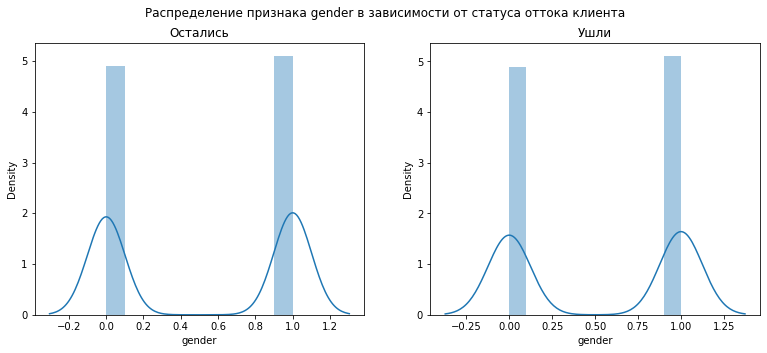

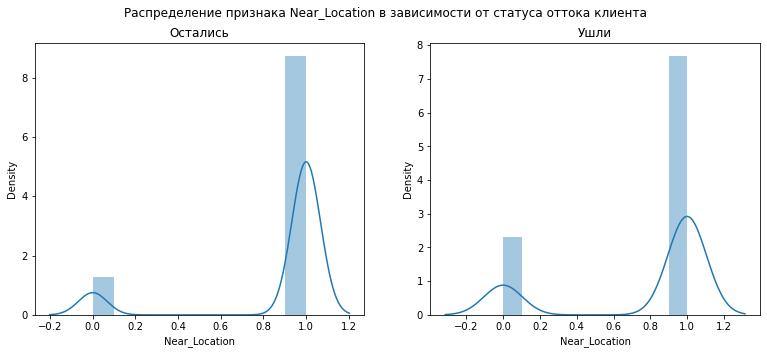

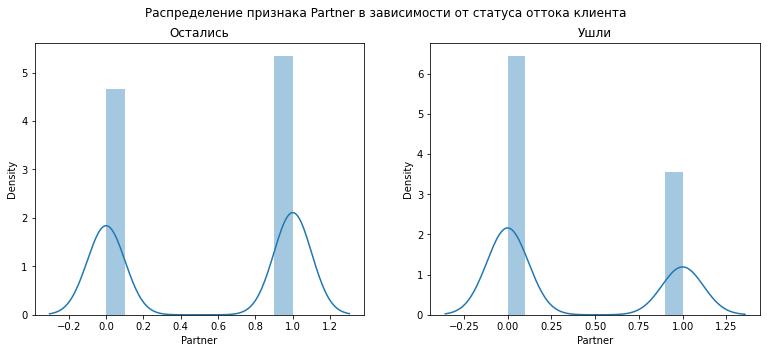

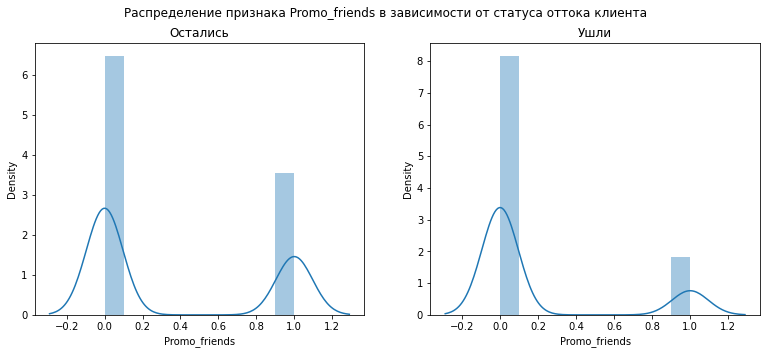

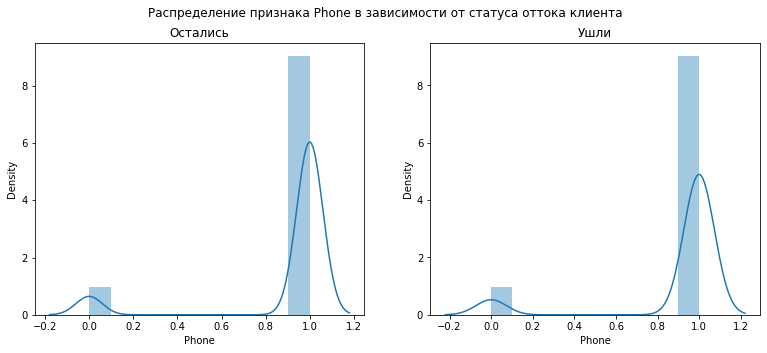

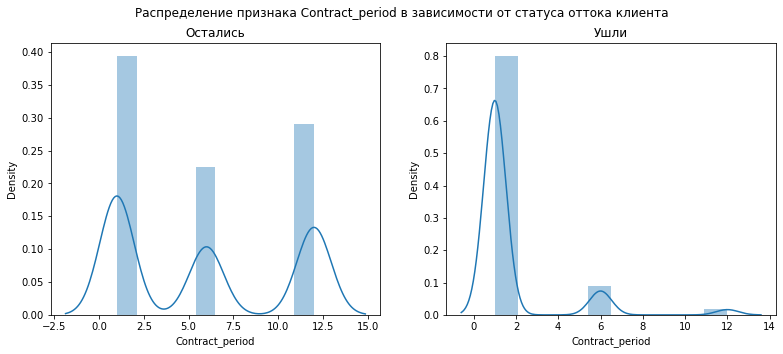

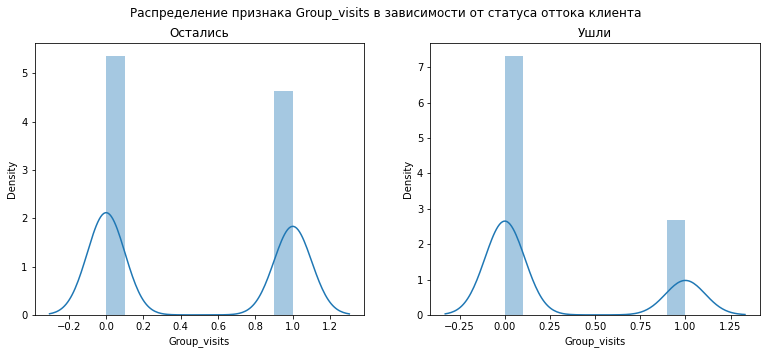

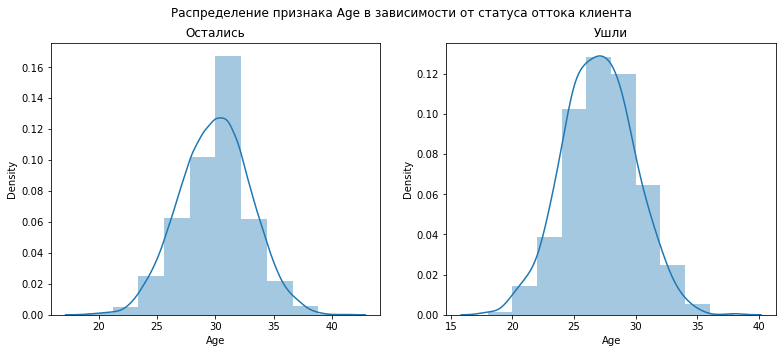

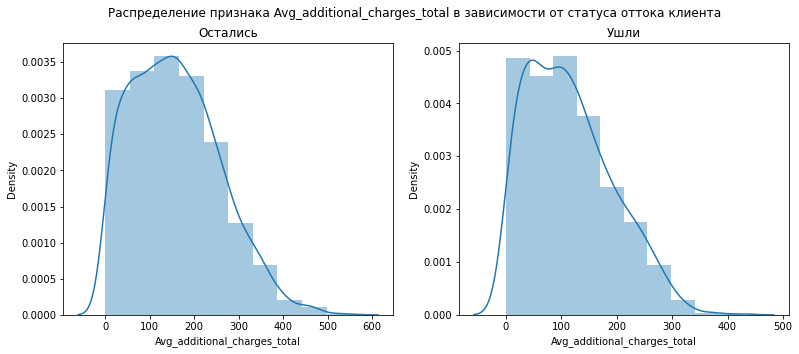

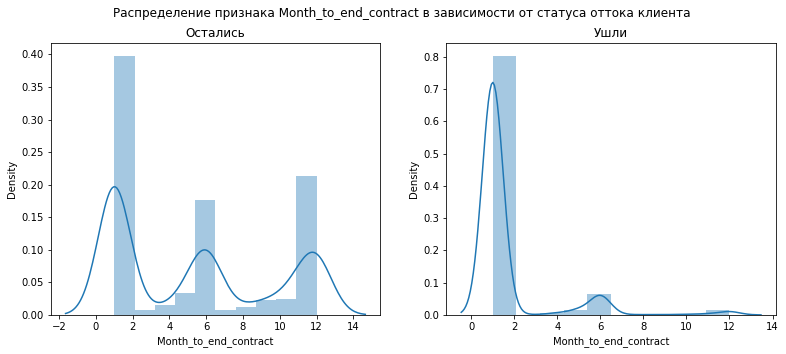

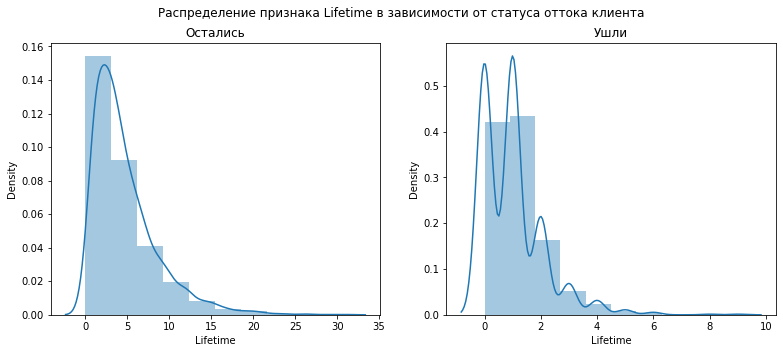

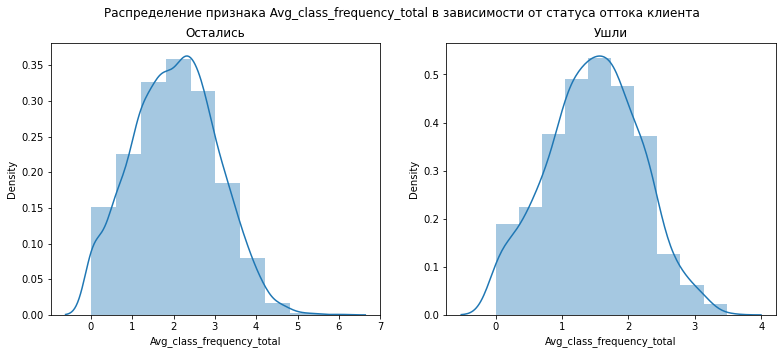

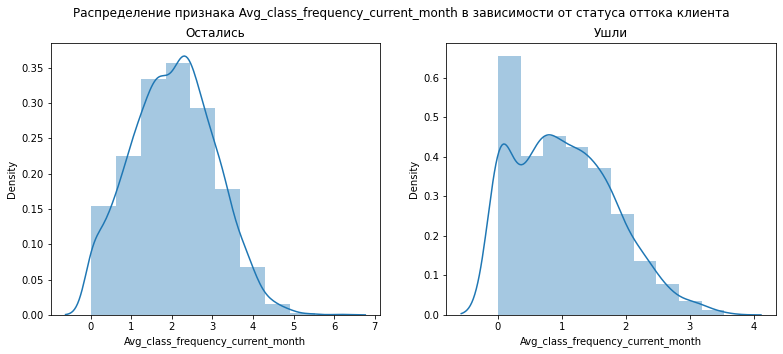

In [6]:
for feature in gym.drop('Churn', axis=1).columns:
    fig, axes = plt.subplots(1, 2)
    fig.set_figheight(5)
    fig.set_figwidth(13)
    fig.suptitle(f'Распределение признака {feature} в зависимости от статуса оттока клиента')
    axes[0].set_title('Остались')
    axes[1].set_title('Ушли')
    sns.distplot(gym.query('Churn == 0')[feature], bins=10, ax=axes[0])
    sns.distplot(gym.query('Churn != 0')[feature], bins=10, ax=axes[1])

plt.show()

О чем нам говорят графики:
- пол не влияет на отток
- среди ушедших клиентов больше тех, кто живет далеко от фитнес-центра
- те, кто пришел по партнерской программе реже попадают в отток
- пришедшие по приглашению друзей так же реже уходят
- заметно меньше в оттоке клиентов с абонементами на 6 и 12 месяцев
- любители групповых занятий - уходят реже
- чаще уходят клиенты 25-30 лет, 30-33 - более стабильные посетители
- ушедшие клиенты меньше тратят денег на сопутствующие товары и услуги
- клиенты отваливаются за 1-2 месяца до истечения абонемента
- лайфтайм клиентов оттока - 2 месяца
- клиенты из оттока зачастую ходят не чаще 1-2 раз в неделю
- в последний месяц перед оттоком клиенты теряют постоянство и ходят реже 1 раза в неделю

Посмотрим на матрицу корреляций:

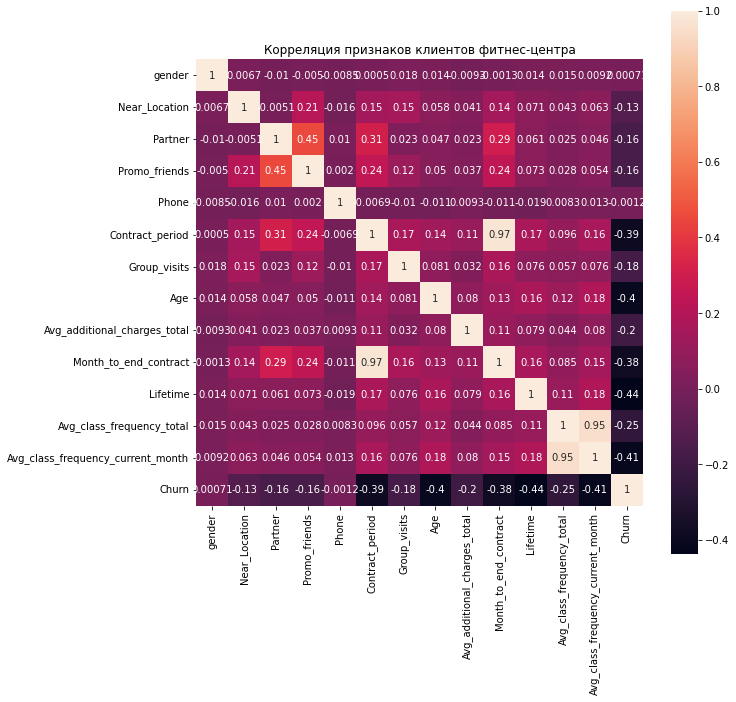

In [7]:
cm = gym.corr()
fig, test = plt.subplots()
test.set_title('Корреляция признаков клиентов фитнес-центра')
fig.set_figheight(10)
fig.set_figwidth(10)
sns.heatmap(cm, annot = True, square=True)
plt.show()

Судя по матрице, с оттоком коррелируют такие показатели как: Avg_class_frequency_current_month, Lifetime, Month_to_end_contract, Age и Contract_period, причем эту корреляцию можно охарактеризовать как среднюю отрицательную.

Между показателем оттока и Avg_class_frequency_total тоже наблюдается отрицательная корреляция, но она слабая.

Положительная средняя корреляция видна у признака Partner с признаками Promo_friends и Contract_period. Слабая положительная корреляция есть у Month_to_end_contract с Partner и Promo_friends, и у Promo_friends и Contract_period.

Также матрица показывает две пары сильно кореллирующих признаков: Avg_class_frequency_current_month - Avg_class_frequency_total и Month_to_end_contract - Contract_period, это говорит о наличии мультиколлинеарности, можно избавиться от одного из каждой пары, чтобы они не смущали нашу будущую модель обучения.

In [8]:
gym = gym.drop(columns=({'Avg_class_frequency_total', 'Contract_period'}))

**Вывод:**

Исследовательский анализ данных позволил обнаружить взаимосвязи между различными признаками и найти признаки, говорящие о возможном оттоке клиентов.

Клиент с большей вероятностью попадет в отток, если он:

- живет или работает далеко от фитнес-центра
- пришел самостоятельно, без партнерки или приглашения от друга
- взял абонемент на 1-2 месяца
- не посещает групповые занятия
- моложе 30 лет
- тратит в районе 100 долларов на сопутствующие товары/услуги или не тратит вовсе
- ходит 1-2 раза в неделю

Показатели, говорящие о том, что клиент готов отвалиться:

- абонемент истекает через 1-2 месяца
- клиент начал ходить реже 1 раза в неделю
- с момента первого посещения прошло 2 месяца

После наложения матрицы корреляции на тепловую карту выявили несколько коррелириующих друг с другом показателей:

Churn (показатель оттока) имеет среднюю отрицательную корреляцию с Avg_class_frequency_current_month, Lifetime, Month_to_end_contract, Age и Contract_period + слабую отрицательную с Avg_class_frequency_total

Положительная средняя корреляция есть у признака Partner с признаками Promo_friends и Contract_period, а также слабая положительная у Month_to_end_contract с Partner и Promo_friends, и у Promo_friends и Contract_period.

Для дальнейшего обучения модели прогнозирования оттока было принято решение убрать по одному признаку из двух пар сильно кореллирующих признаков: Avg_class_frequency_total и Contract_period, чтобы избежать переобучения.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

In [9]:
X = gym.drop('Churn', axis = 1)
y = gym['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

models = [LogisticRegression(random_state=0), RandomForestClassifier(random_state=0)]

def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        f'Accuracy {m}: {round(accuracy_score(y_test, y_pred), 2)}\n', 
        f'Precision {m}: {round(precision_score(y_test, y_pred), 2)}\n',
        f'Recall {m}: {round(recall_score(y_test, y_pred), 2)}\n'
    )
    
for m in models:
    make_prediction(m, X_train, y_train, X_test, y_test)

Accuracy LogisticRegression(random_state=0): 0.9
 Precision LogisticRegression(random_state=0): 0.79
 Recall LogisticRegression(random_state=0): 0.8

Accuracy RandomForestClassifier(random_state=0): 0.91
 Precision RandomForestClassifier(random_state=0): 0.83
 Recall RandomForestClassifier(random_state=0): 0.79



**Вывод**

Обучение модели алгоритмом случайного леса дает долю верных ответов - 0.91, что чуть выше, чем дает логистическая регрессия, при этом, случаный лес выигрывает в точности - 0.83 против 0.79, но чуть проигрывает в полноте - 0.79 против 0.8.

Стоит остановить выбор на модели, обученной на алгоритме случайного леса.

## Кластеризация клиентов

Стандартизируем данные:

In [10]:
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)

Построим матрицу расстояний и дендрограмму:

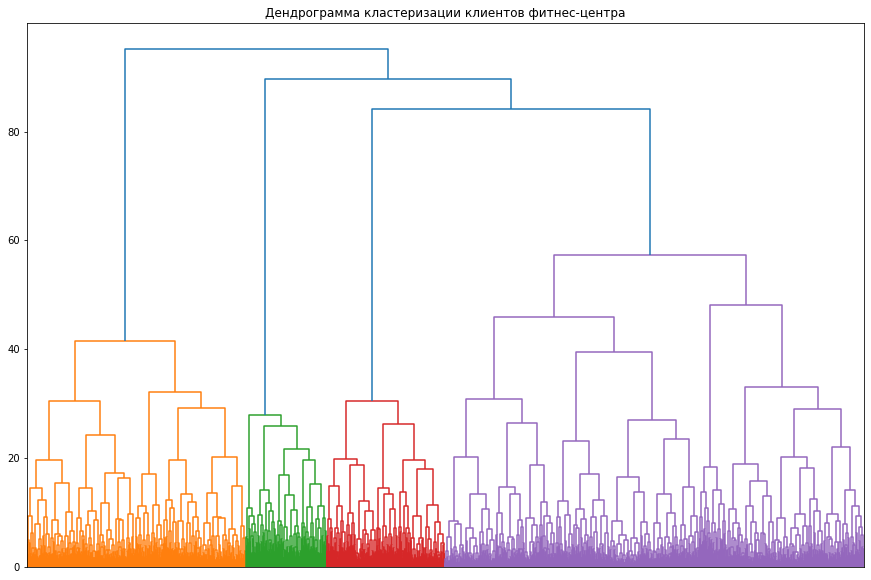

In [11]:
linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, no_labels = True, orientation='top')
plt.title('Дендрограмма кластеризации клиентов фитнес-центра')
plt.show() 

На дендрограмме выделено 4 кластера.

**Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов**

*Не смотря на то, что дендрограмма отрисовала 4 кластера, задача учебного проекта - спрогнозировать 5 кластеров.*

In [12]:
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc) 

gym['cluster_km'] = labels

print(gym.groupby(['cluster_km']).mean())

              gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km                                                               
0           0.492000       0.994000  0.953000       1.000000  0.906000   
1           0.495352       0.998672  0.378486       0.046481  0.903054   
2           0.511194       1.000000  0.226368       0.114428  0.899254   
3           0.502455       0.000000  0.489362       0.072013  0.913257   
4           0.550481       0.998798  0.274038       0.075721  0.897837   

            Group_visits        Age  Avg_additional_charges_total  \
cluster_km                                                          
0               0.528000  29.633000                    154.086252   
1               0.000000  30.342629                    174.392898   
2               0.182836  26.807214                    111.073289   
3               0.232406  28.700491                    137.375245   
4               1.000000  30.248798                    155.206260  

Алгоритм спрогнозировал 5 кластеров. По средним видно, что некоторые кластеры четко разделены по близости к фитнес-центру, наличию промокода от друга и посещению групповых программ.

**Отрисуем распределения признаков для кластеров:**

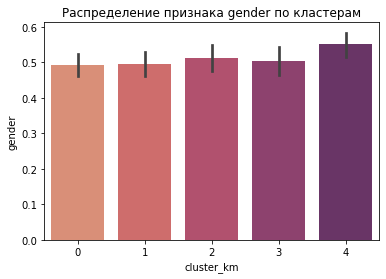

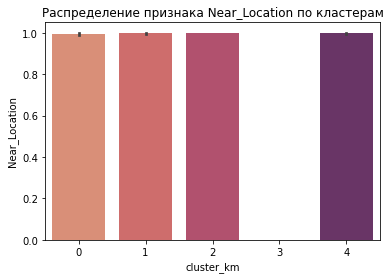

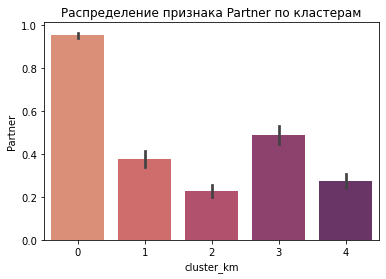

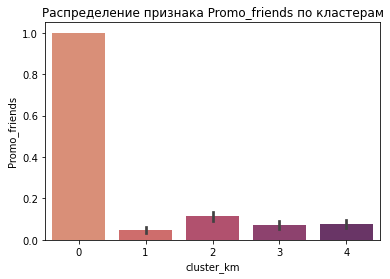

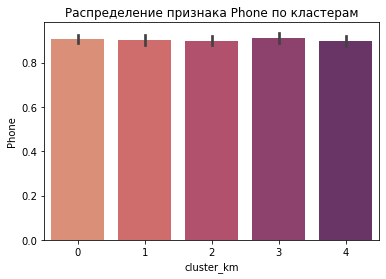

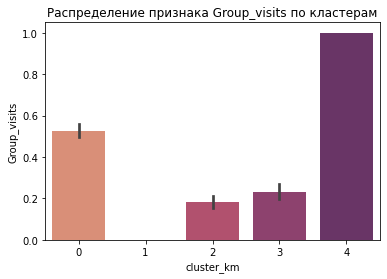

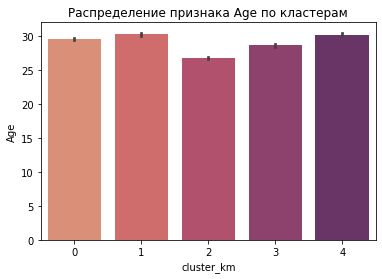

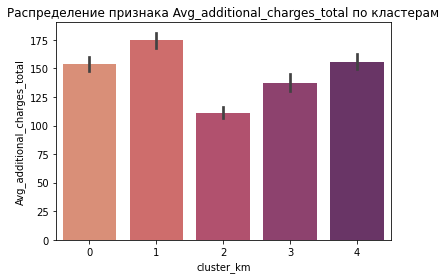

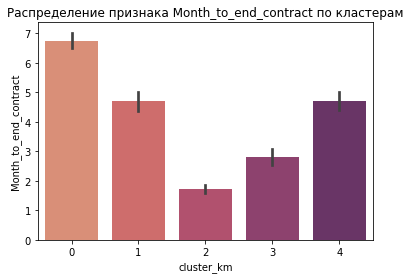

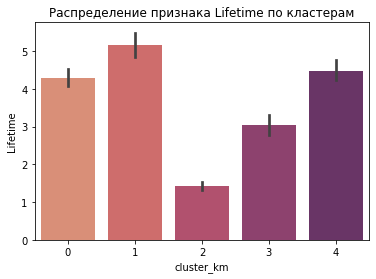

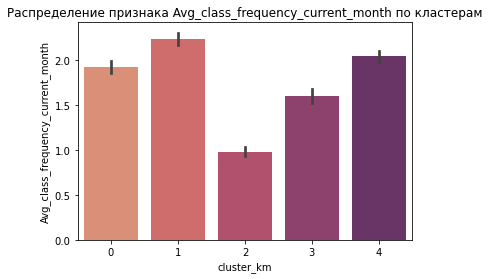

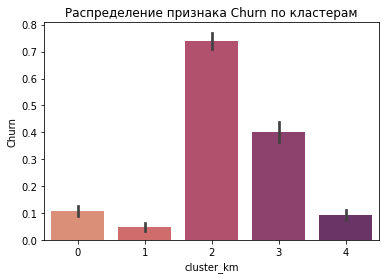

In [13]:
for feature in gym.drop('cluster_km', axis=1).columns:
    plt.title(f'Распределение признака {feature} по кластерам')
    sns.barplot(data=gym, x="cluster_km", y=feature, palette = 'flare')
    plt.show()

Опираясь на гистограммы можно предположить, что такие признаки как пол, возраст и оставленный номер телефона никак не участвуют в кластеризации и распределены равномерно по всем кластерам.

В один кластер (3) собраны только клиенты, живущие/работающие далеко от фитнес-центра, в другой (2) наоборот, только находящиеся рядом.

Кластер (0) собрал в себе только тех, кто пришел по промокоду и большую часть тех, кто пришел по партнерским программам.

В кластер (4) отобрали только любителей групповых программ, а в кластер (1) наоборот.

Остальные признаки в различных соотношениях распределены по 5 кластерам.

**Посчитаем долю оттока для каждого кластера**

In [14]:
gym.groupby(['cluster_km']).mean()['Churn']

cluster_km
0    0.108000
1    0.046481
2    0.741294
3    0.400982
4    0.092548
Name: Churn, dtype: float64

В итоге кластер 2 собрал в себе больше всего отвалившихся клиентов, также клиенты из кластера 3 тоже показывают значительную долю оттока.

**Вывод**

В результате проведенной кластеризации получили 5 кластеров, их можно разделить по ярковыраженным признакам:

- 0 - клиенты, привлеченные промокодом или партнерской программой
- 1 - клиенты, не посещающие групповые занятия
- 2 - клиенты, живущие/работающие поблизости
- 3 - клиенты, живущие/работающие далеко от фитнес-центра 
- 4 - любители групповых программ

все остальные признаки присутсвуют во всех кластерах в большей или меньшей степени, такие признаки как пол, возраст и оставленный номер телефона равномерно распределены по кластерам и не влияют на относение клиента к той или иной группе.

Стоит отметить, что больше всего ушедших клиентов в кластерах 2 и 3, помимо того, что один из кластеров (3) содержит только клиентов, далеко живущих/работающих от фитнес-центра, а другой (2) наоборот, можно выделить следующие особенности обоих кластеров: 

- меньше всего посещений в неделю в последних месяц перед оттоком
- самый короткий лайфтайм
- меньше всего месяцев до конца контракта
- меньше всего трат на допы
- мало любителей групповых программ

Среди самых надежных можно выделить кластеры 1 и 4, которые разделены на любителей и противников групповых программ, и кластер 0, где собрались клиенты, пришедшие по промокоду. 


## Выводы и базовые рекомендации по работе с клиентами

Сформулируем признаки клиента, потенциально попадающего в отток:

- живет или работает в районе, отличном от района, в котором расположен фитнес-центр
- купил абонемент меньше, чем на 6 месяцев
- ходит не чаще 2 раз в неделю и за месяц до окончания абонемента стал ходить еще реже
- тратит в районе 100 долларов на допуслуги

Получается, что по первым двум признакам можно заранее определить группу риска.

Далее, со временем собираем данные по двум другим признакам и получаем основания полагать, что клиент скоро отвалится.

Для того, чтобы предотвратить отток, можно в последний месяц действия контракта клиента предложить продление со скидкой, дополнительными месяцами или сертификатом на допуслуги (как и делают все фитнес-центры).

О надежности клиента могут говорить следующие признаки:

первичные
- пришел по промокоду друга
- контракт на 6 месяцев и дольше
- живет или работает поблизости

вторичные
- ходит 2 раза в неделю и больше
- тратит от 150 долларов на допуслуги
- до конца контракта больше 4 месяцев